### Diseño FIR:
Para diseñar el filtro FIR se utilizo la funcion firwin2 y se fue vairendo el modelo de ventana hasta obtener las que mejor se adaptaban. Las que mejor se adaptaron fueron carbox y hamming finalmente nos quedamos con hamming devido a que la misma presenta menos ondulaciones en la banda de eliminacion lo cual podria reducir el ruido al momento de filtrar la señal.

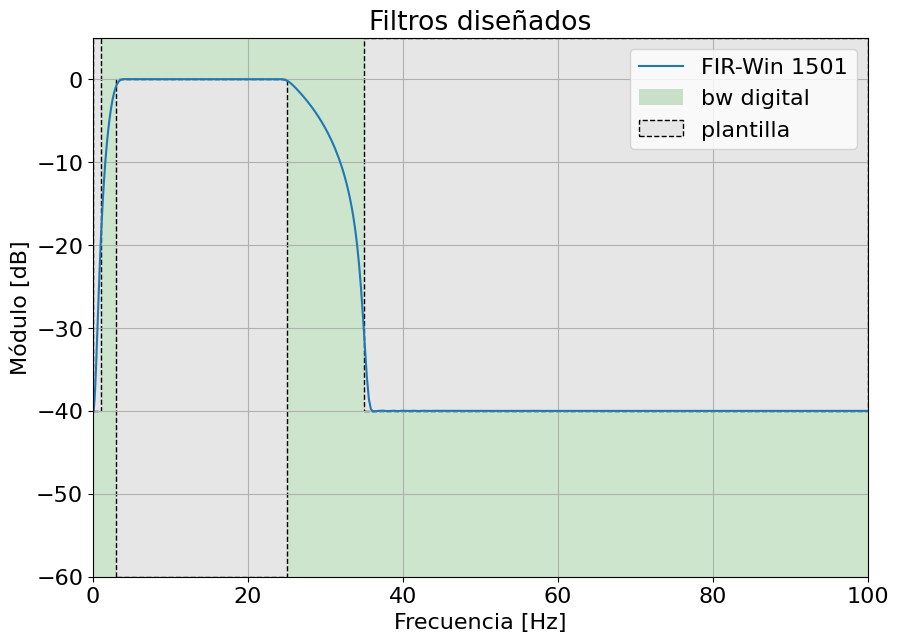

In [10]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')

mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
ws = 2*np.pi*fs
nyq_frec = fs / 2
cant_coeficientes = 1501
npuntos = 1000000 ## Numero de putos para graficar

# Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

fs1 = 1.0 #Hz
fp1 = 3.0 #Hz
fp2 = 25.0 #Hz
fs2 = 35.0 #Hz

##
# pasa banda
frecs = np.array([0, fs1, fp1, fp2, fs2, fs/2])/fs*2
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

# algunas ventanas para evaluar
#win_name = 'boxcar'     # Cumple el objetivo pero con una senuciodial en la en la zona atenuada
win_name = 'hamming'    # No cumple completamente el objetivo pero se hacerca bastante y por lo cual se lo concidera valido
#win_name = 'blackmanharris'
#win_name = 'flattop'

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window = win_name )
den_win = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w = np.logspace(0, ws/2, npuntos)/ws

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


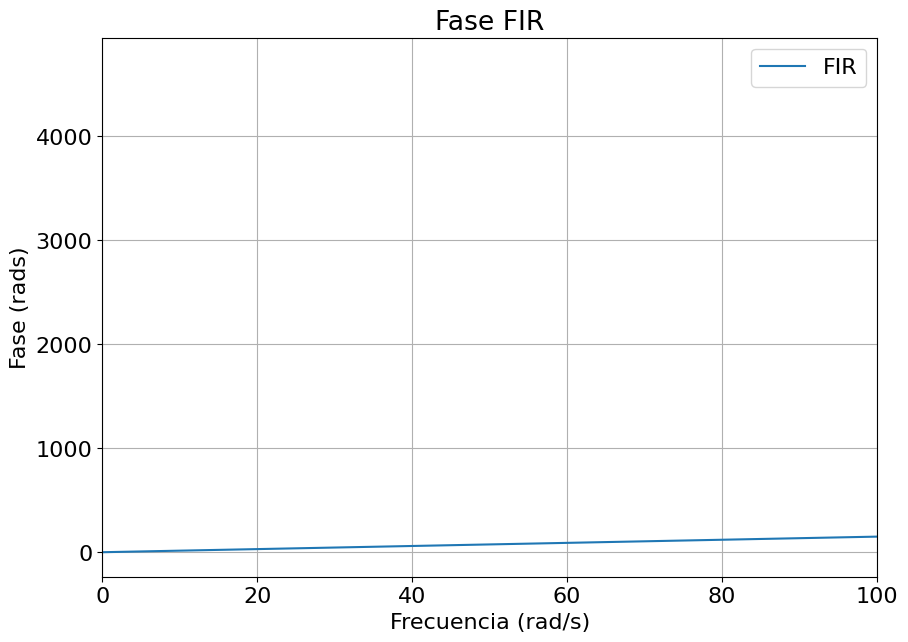

In [11]:
npoints_win = 10000

tf_win = sig.TransferFunction(num_win, den_win, dt=1/fs)
w_win, mag_win, phase_win = tf_win.bode(npoints_win)

plt.figure(1)
plt.plot(w_win, phase_win*2*np.pi/180, label=('FIR'))
plt.grid(True)
plt.title('Fase FIR')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Fase (rads)')
plt.legend()
plt.xlim(0,100)
#plt.ylim(-10,10)
# Mostrar el gráfico
plt.show()

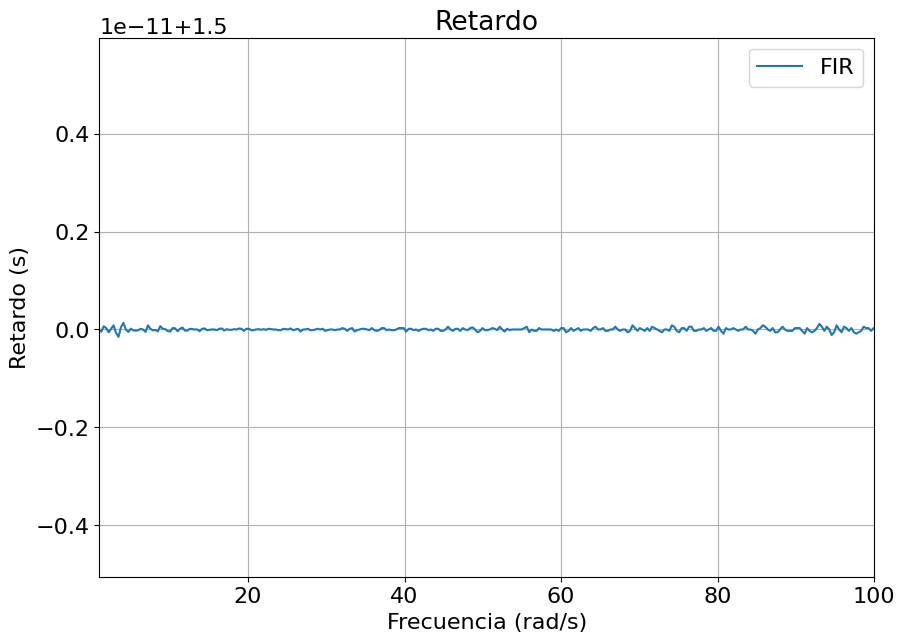

In [7]:
retar_win = np.gradient(phase_win*2*np.pi/180,w_win)
plt.figure(2)
plt.plot(w_win, retar_win, label='FIR')
plt.grid(True)
plt.title('Retardo')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Retardo (s)')
plt.legend()
plt.xlim(1,100)
# Mostrar el gráfico
plt.show()

### Diseño IIR:
Para el diseño del filtro IIR se probo con filtros tipo butterworth, cheby1, cheby2 y elepiticos. Teniendo el mejor resultado en el filtro eliptico, menor orden y menor ruido. Sin embargo aunque se utilizo el filtro mensionado el mismo no cumple por completo la platilla devido al ser una plantilla muy execiva el filtro tiene complicaciones al subir su orden.

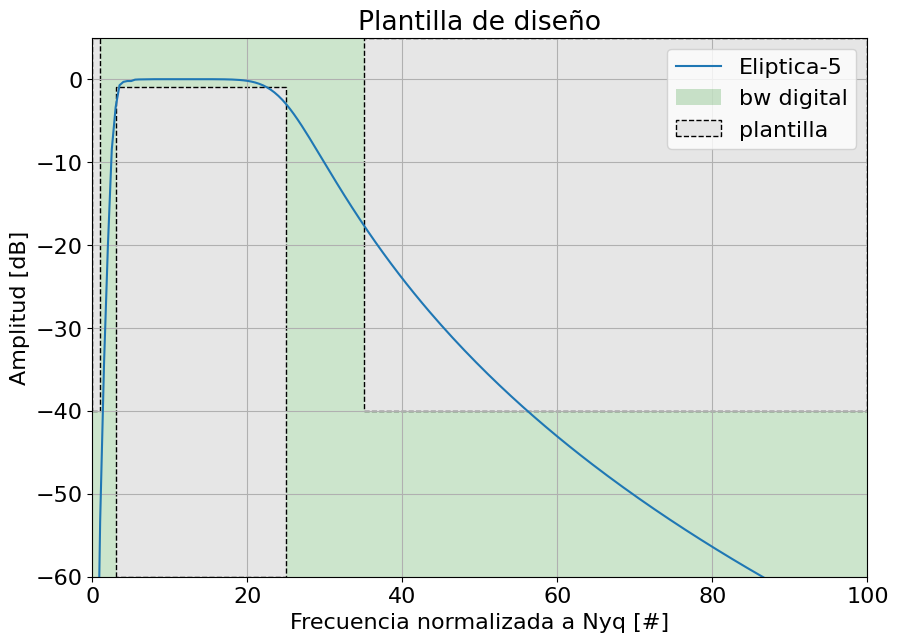

In [18]:
import numpy as np
import scipy.signal as sig
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
from pytc2.sistemas_lineales import plot_plantilla

fs = 1000
fs_n = fs/2

fs1 = 1
fp1 = 3
fp2 = 25
fs2 = 35

fpass = np.array( [fp1/fs_n, fp2/fs_n] ) 
ripple = 1 # dB
fstop = np.array( [fs1/fs_n, fs2/fs_n] ) 
attenuation = 40 # dB

# Ne fijo el orden que necesita el filtro y donde se encuentra la frecuencia de corte
orderz, wcutofz = sig.ellipord( fpass, fstop, ripple, attenuation, analog=False)

numz, denz = sig.iirfilter(orderz, wcutofz, rp=ripple, rs=attenuation, btype="bandpass", analog=False)
tf_iir = sig.TransferFunction(numz, denz, dt=1/fs)

# Plantilla de diseño

plt.figure(1)
plt.cla()

npoints = 1000
w_nyq = 2*np.pi*fs/2

w, mag, phase = tf_iir.bode(npoints)
plt.plot(w/w_nyq*fs_n, mag, label=("Eliptica-")+ str(orderz))

plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

plt.axis([0, 100, -60, 5 ]);

plot_plantilla(filter_type = "bandpass" , fpass = fpass*fs_n, ripple = ripple , fstop = fstop*fs_n, attenuation = attenuation, fs = fs)


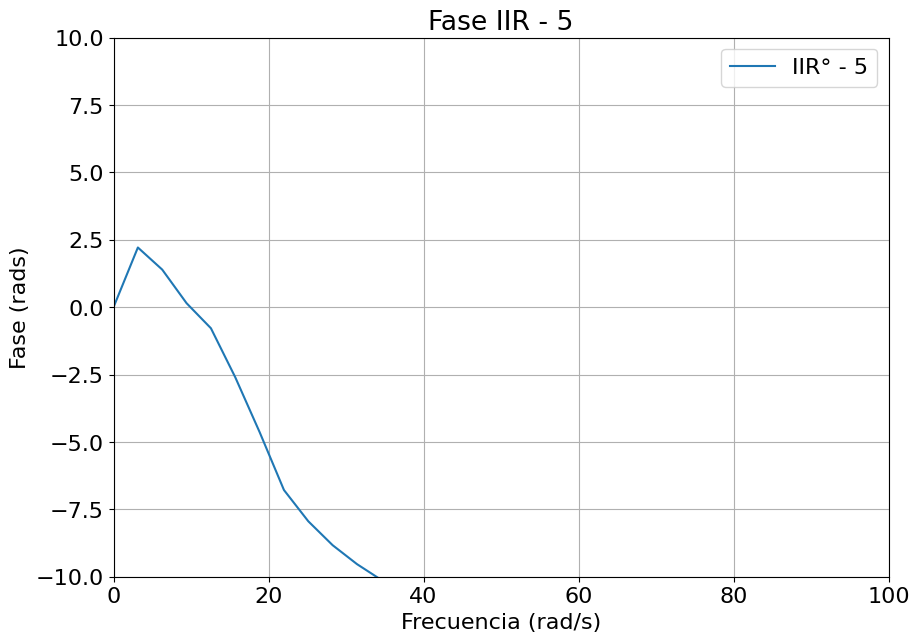

In [53]:
plt.figure(1)
plt.plot(w_, phase*2*np.pi/180, label=('IIR° - '+str(orderz)))
plt.grid(True)
plt.title('Fase IIR - '+str(orderz))
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Fase (rads)')
plt.legend()
plt.xlim(0,100)
plt.ylim(-10,10)
# Mostrar el gráfico
plt.show()

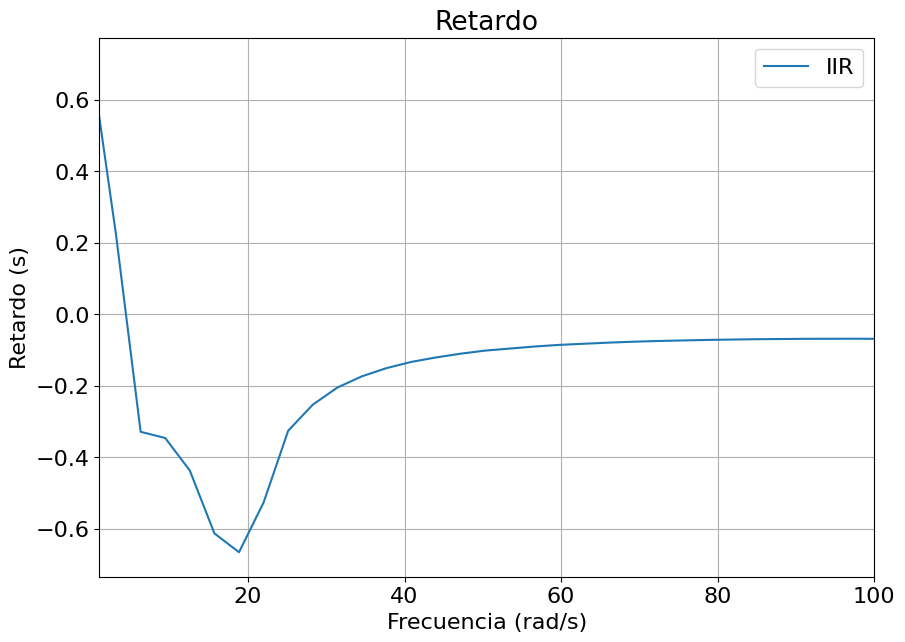

In [54]:
retar = np.gradient(phase*2*np.pi/180,w_)
plt.figure(2)
plt.plot(w_, retar, label='IIR')
plt.grid(True)
plt.title('Retardo')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Retardo (s)')
plt.legend()
plt.xlim(1,100)
# Mostrar el gráfico
plt.show()

## Conclucion de la primera parte:
Se pudo concluir que la creacion de un filtro IIR es mucho mas complejo que un filtro FIR debido a los polos fuera del origen, estos logran un menor orden pero hacen que el filtro tenga problemas al aumentar el orden. Por otro lado el filtro FIR alcanza rapidamente un orden alto pero el aumento no deforma el bode como si lo hace el IIR.

# Parte 2:
https://nbviewer.org/github/marianux/jupytest/blob/master/Laboratorio%20de%20filtrado%20digital.ipynb

### Los siguientes graficos muestran las respuesta del filtro Fir diseñado tras filtrar un electrocardiograma

In [12]:
# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_fir = sig.lfilter(num_win, den_win, ecg_one_lead)

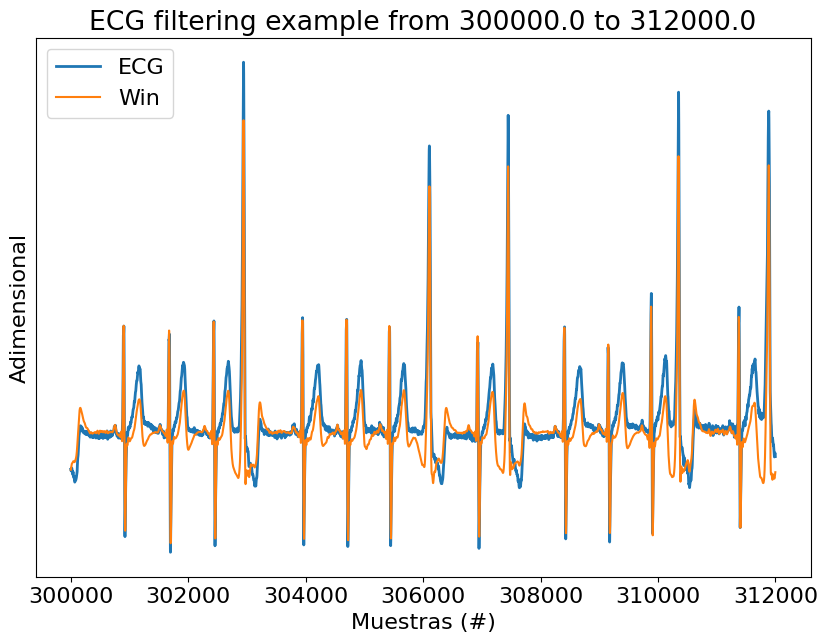

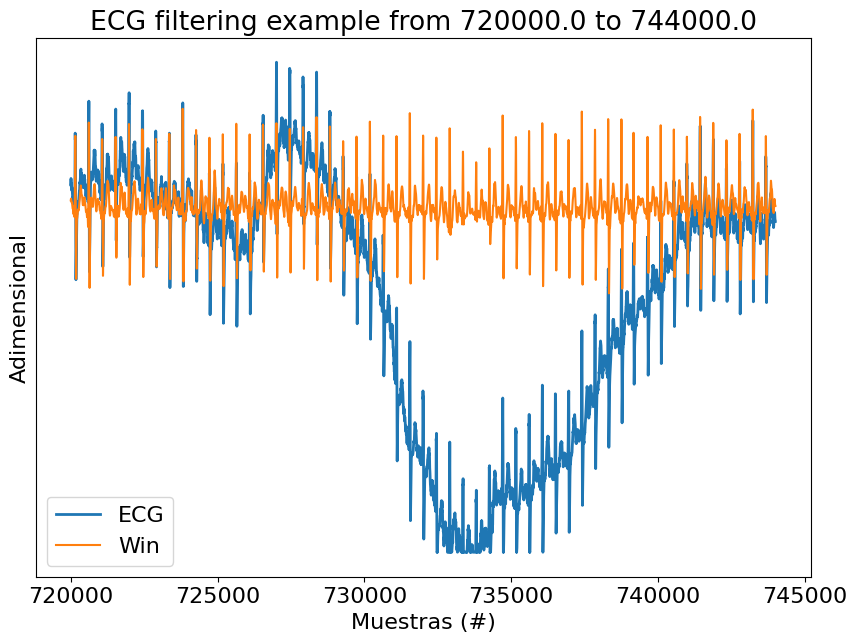

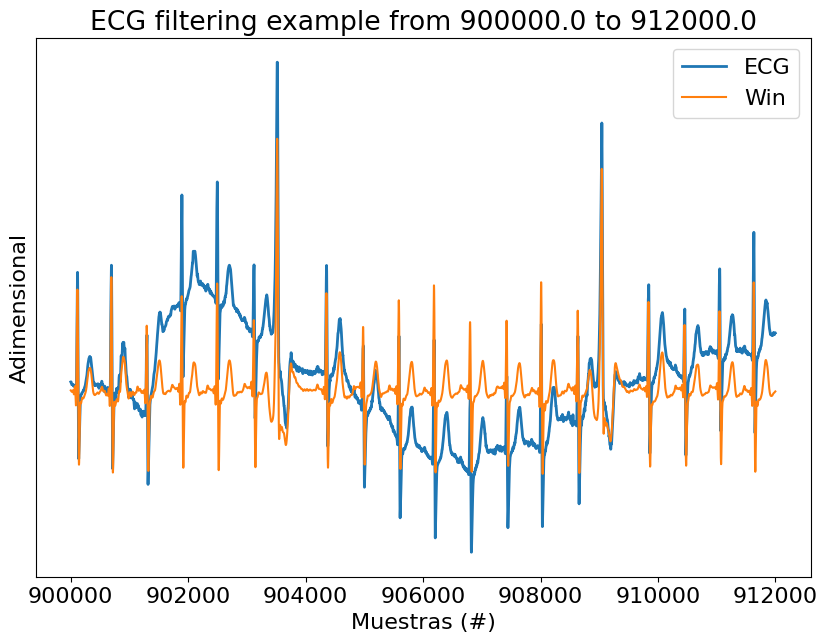

In [15]:


# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_fir[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

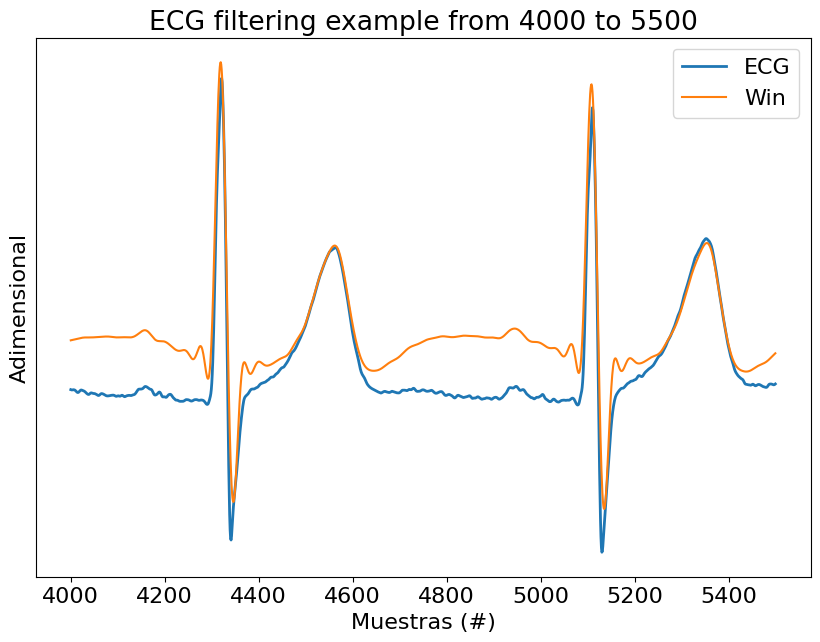

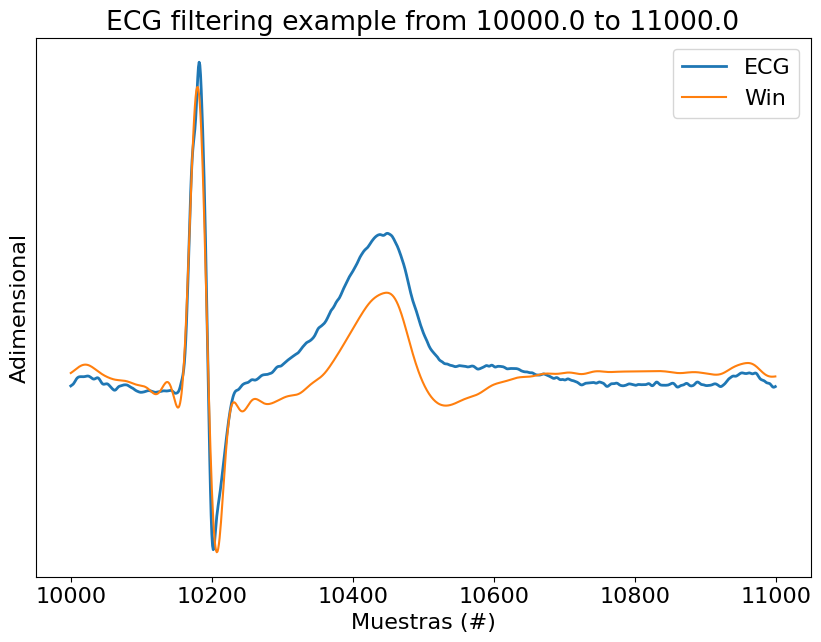

In [16]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_fir[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se pueden observar en estos graficos de comparatoria el filtro FIR armado no esta en sicronismo con la señal original eso se debe a que el filtro diseñado posee una cierda demora respecto a la señal original. Otra observacion es tras aplicar el filtro es la aparicion de nuevas perturbaciones tras la subida del primer riple. En este caso se puede observar una pequeñal montaña que surgio con el filtro.

# IIR:

In [38]:
from scipy import signal
# IIR
#ECG_f_iir = sig.sosfilt(signal.tf2sos(numz, denz), ecg_one_lead)
ECG_f_iir = sig.lfilter(numz, denz, ecg_one_lead)  #Se esta utilizando el lfilter por ser un iir de bajo orden

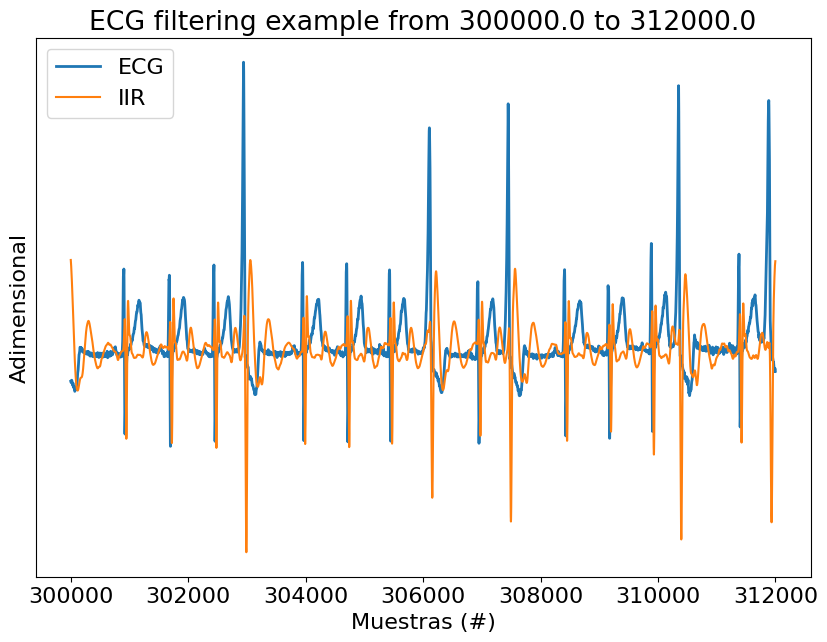

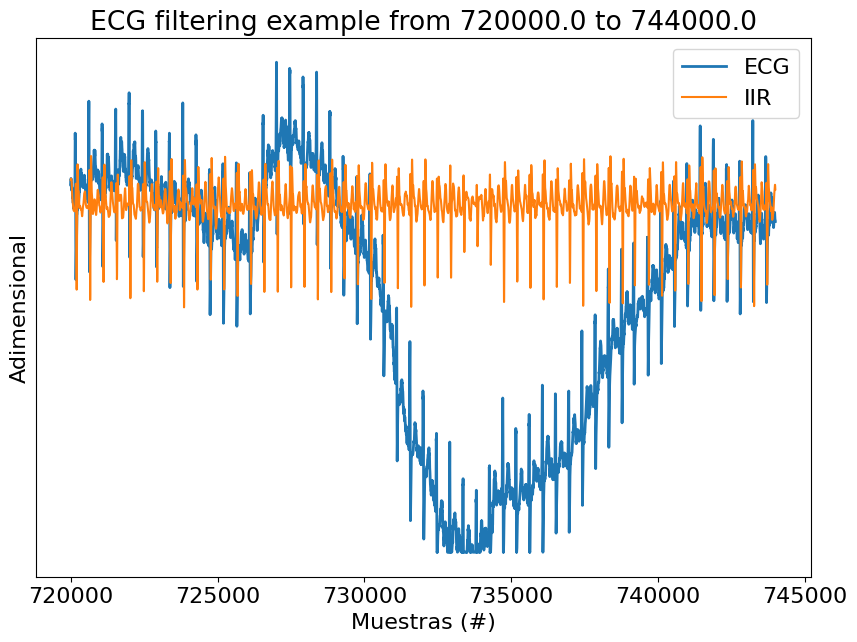

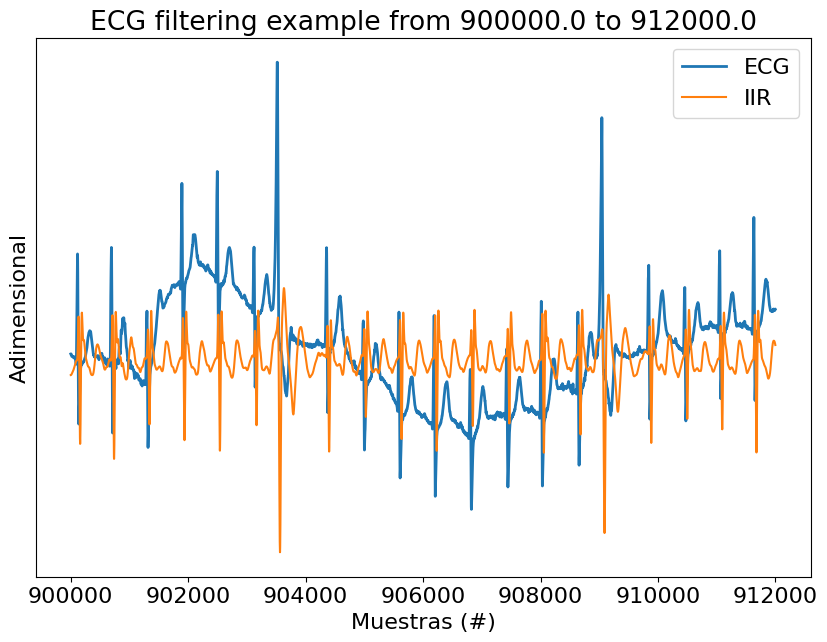

In [39]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 0


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    plt.plot(zoom_region, ECG_f_iir[zoom_region + demora], label='IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

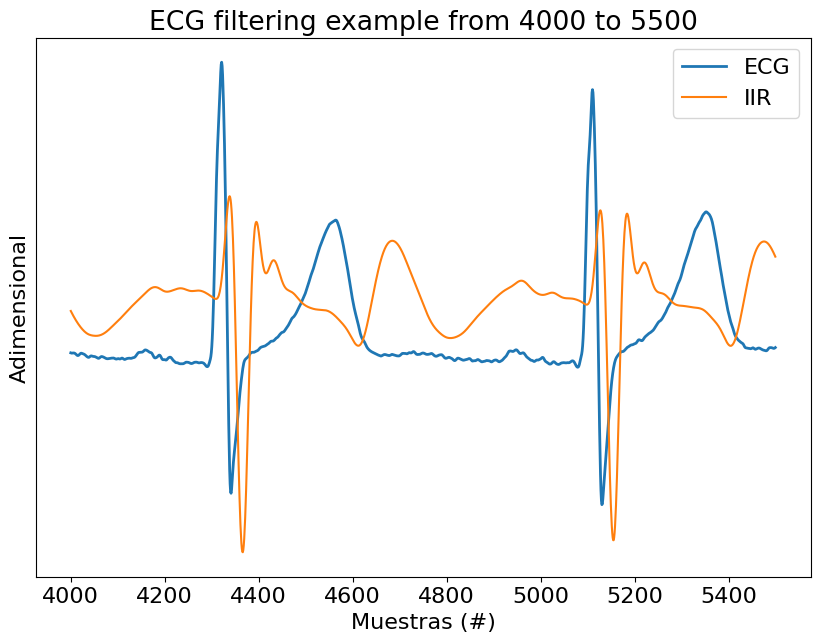

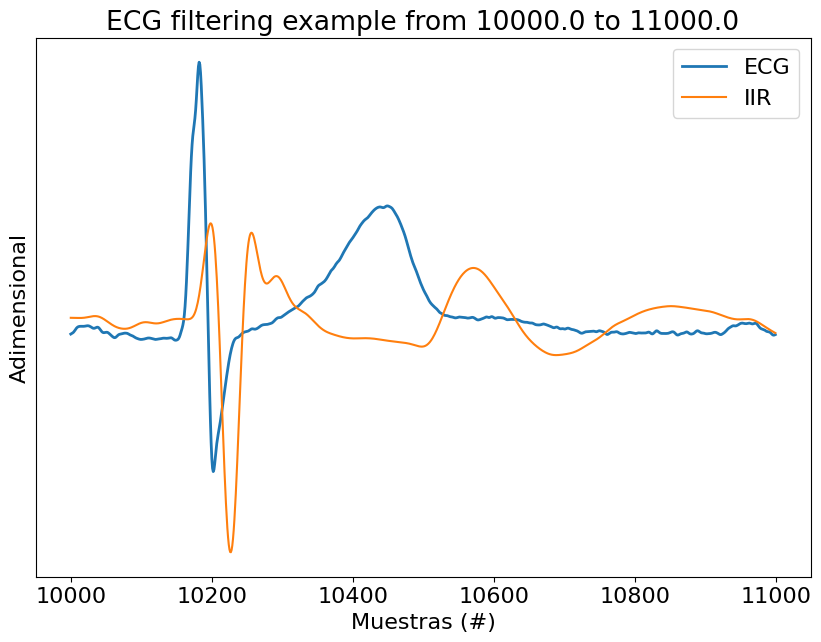

In [40]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    plt.plot(zoom_region, ECG_f_iir[zoom_region + demora], label='IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

A diferencia del filtro FIR obtenido el filtro IIR diseñado con pyfda no puede mantener correctamente la informacion de la señal ingresada haciendo que la misma se pierda.

# Filtrado Bidirreccional para correccion de filtrado:
Un metodo para reducir la distorcion de la señal es con el uso de un filtrado bidireccional, esto lo podremos hacer con la funcion scipy.signal.filtfilt. de scipy.

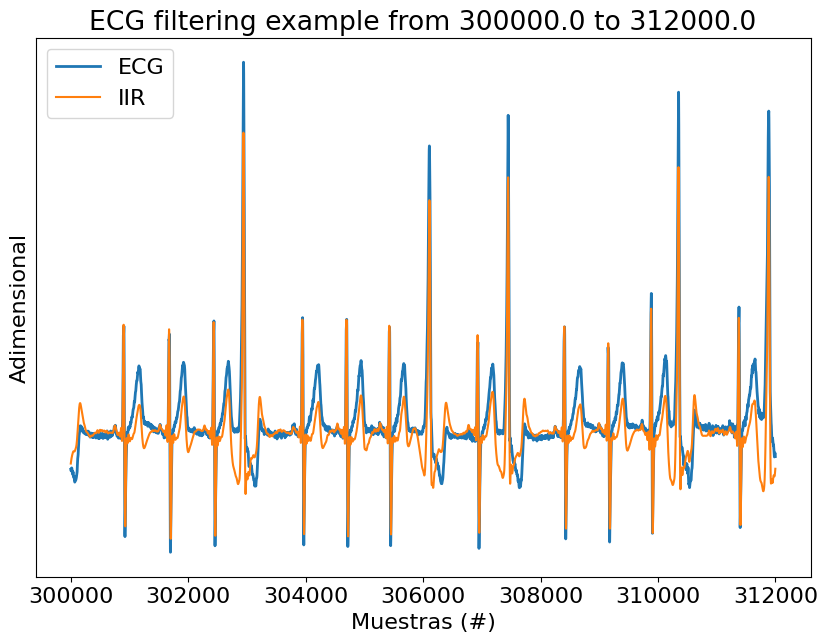

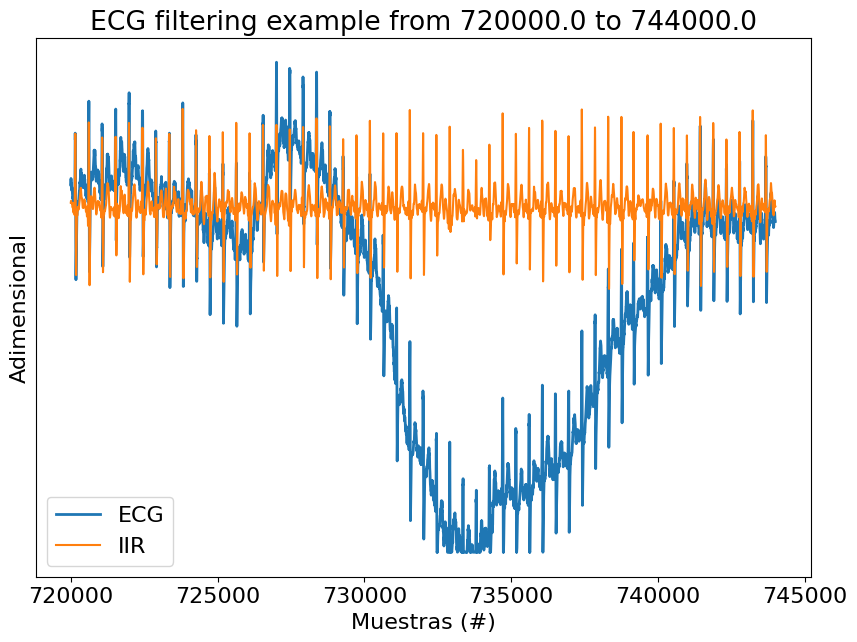

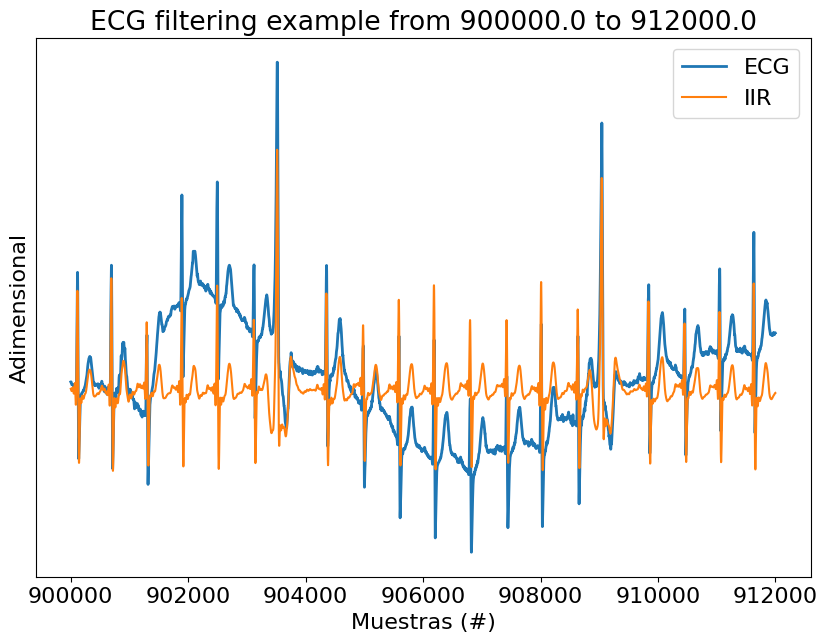

In [46]:
# Procedemos al filtrado
ECG_f_iir = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

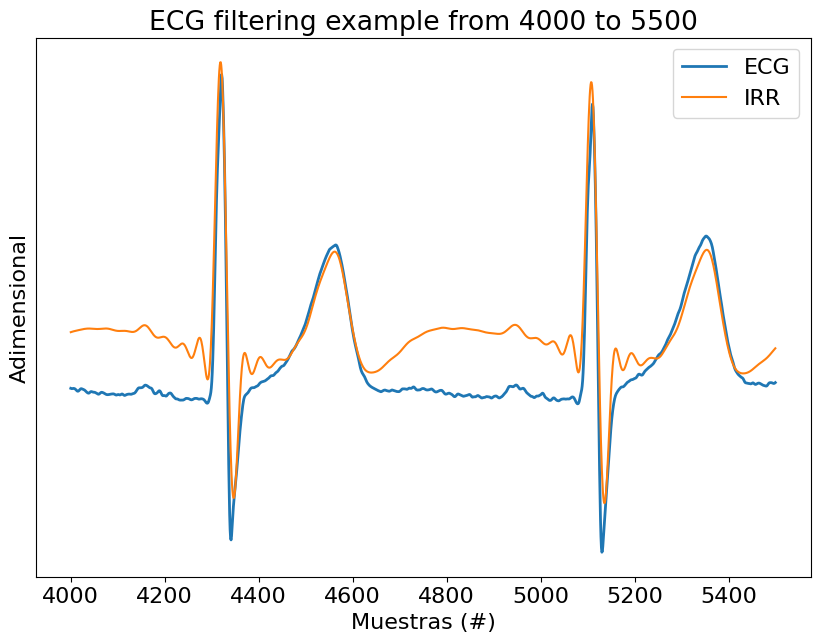

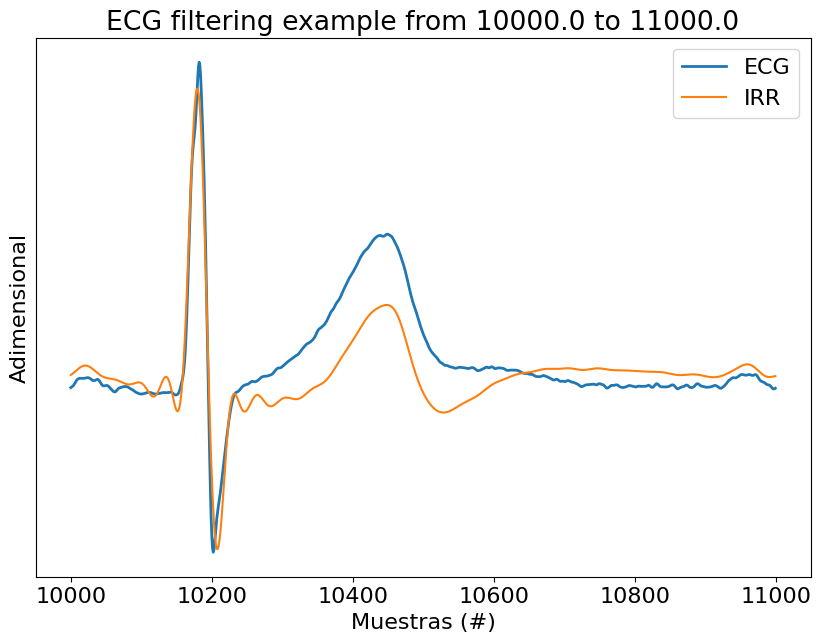

In [47]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    #plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se puede obserbar hubo una gran mejora entre el filtro arreglado el filtrado bidireccional con el filtrado simple pero devido al filtro eliptico utilizado la señal no se pudo recuperar completamente.

# Preguntas:

$¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?$  
  
Se logro un buen filtrado para el filtro FIR mientras que el filtro IIR no pudo lograrlo con la misma eficacia. Desde mi punto de vista, la razón detrás de la incapacidad del filtro IIR para producir una señal filtrada con baja distorsion se debe a la elección del tipo de filtro. En este caso, se empleó un filtro elíptico, conocido por su rápida transición, pero que a costa de ello exhibe un comportamiento sinusoide en todo su rango, lo que conlleva a una considerable distorcion la cual no se pudo corregir con el filtrado bilineal. Si se hubiera optado por un filtro Butterworth IIR, posiblemente se habría logrado una mejor reconstrucción de la señal, ya que este tipo de filtro presenta menos variación de amplitud en comparación con el filtro elíptico.

$¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?$  

El filtro filtra por señales sin considerar que las mismas poseen o no informacion, debido a esto el filtro contamina la informacion para poder atenuar el ruido.